In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        # Define FS parameters (now as learnable parameters)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Softplus

K=4

Epoch 1/20000, Loss: 21.09236717224121
Epoch 1001/20000, Loss: 6.888075828552246
Epoch 2001/20000, Loss: 2.2857635021209717
Epoch 3001/20000, Loss: 0.8295222520828247
Epoch 4001/20000, Loss: 0.4464017152786255
Epoch 5001/20000, Loss: 0.33408769965171814
Epoch 6001/20000, Loss: 0.271007239818573
Epoch 7001/20000, Loss: 0.2497316598892212
Epoch 8001/20000, Loss: 0.21641871333122253
Epoch 9001/20000, Loss: 0.1394125521183014
Epoch 10001/20000, Loss: 0.12539878487586975
Epoch 11001/20000, Loss: 0.12486149370670319
Epoch 12001/20000, Loss: 0.12477034330368042
Epoch 13001/20000, Loss: 0.1247517392039299
Epoch 14001/20000, Loss: 0.12474532425403595
Epoch 15001/20000, Loss: 0.12474606186151505
Epoch 16001/20000, Loss: 0.12474263459444046
Epoch 17001/20000, Loss: 0.1247473955154419
Epoch 18001/20000, Loss: 0.12474627047777176
Epoch 19001/20000, Loss: 0.1247413158416748
Loss values: [21.09236717224121, 16.773561477661133, 13.34704875946045, 10.697495460510254, 8.58875560760498, 6.888075828552246

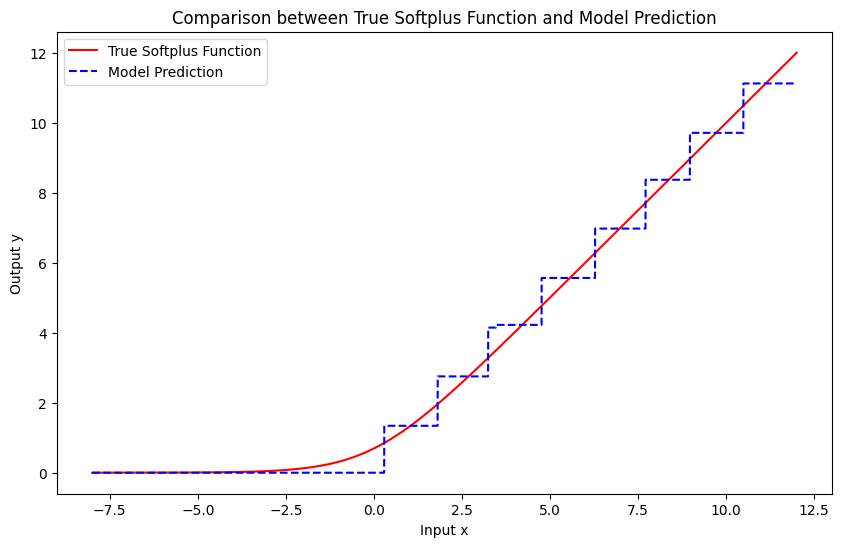

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

In [ ]:
# Instantiate model and initial setup
num_params = 8 # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 7.365235805511475
Epoch 1001/20000, Loss: 0.4564765989780426
Epoch 2001/20000, Loss: 0.07658940553665161
Epoch 3001/20000, Loss: 0.04091774299740791
Epoch 4001/20000, Loss: 0.030179927125573158
Epoch 5001/20000, Loss: 0.027927471324801445
Epoch 6001/20000, Loss: 0.025605332106351852
Epoch 7001/20000, Loss: 0.024145454168319702
Epoch 8001/20000, Loss: 0.021938376128673553
Epoch 9001/20000, Loss: 0.019862810149788857
Epoch 10001/20000, Loss: 0.016573626548051834
Epoch 11001/20000, Loss: 0.01348465122282505
Epoch 12001/20000, Loss: 0.012525029480457306
Epoch 13001/20000, Loss: 0.009124623611569405
Epoch 14001/20000, Loss: 0.007200132589787245
Epoch 15001/20000, Loss: 0.006224305834621191
Epoch 16001/20000, Loss: 0.005744466092437506
Epoch 17001/20000, Loss: 0.0058070579543709755


k=12

In [ ]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

In [ ]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=20

In [ ]:
# Instantiate model and initial setup
num_params = 20  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=24

In [ ]:
# Instantiate model and initial setup
num_params = 24  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

#x_train = torch.cat((
#    torch.linspace(-8, -5, steps=5000),
#    torch.linspace(-5, 0, steps=60000),
#    torch.linspace(0, 12, steps=35000)
#)).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()